# Building Data Cube Mining
## Pattern identification with SAX

This script performs pattern identification over three cuboids of the open building data genome project 2 set, namely {time, site}, {time, attribute} and {attribute, site}.
The data is first manipulated for cube slicing. SAX transformation is then performed per cuboid over normalized daily sequences and results are presented visually.

In [11]:
import pandas as pd
import numpy as np
import time
from glob import glob

In [64]:
# Path definition & Parameter Selection
meter_data = ["electricity", "gas", "hotwater", "chilledwater"]
weather_cols = ["airTemperature", "windSpeed", "cloudCoverage"]
path_meters = "..\\data\\meters\\cleaned\\"
path_meta = "..\\data\\metadata\\"
path_weather = "..\\data\\weather\\"
path_out = "..\\figures\\SAX_pattern_identification\\"
files = [path_meters + meter+ "_cleaned.csv" for meter in meter_data]

### Reading

Dataframes are organized in a multicolumn fashion {meter, building_id}

In [22]:
def set_upperlevel_column(df, upperlevel_column_name):
    """"A function to define an upper level column over a dataframe."""
    lowerlevel_column_name = df.columns
    tuple_column = []
    for i in lowerlevel_column_name:
        tuple_column.append((upperlevel_column_name, i))
    df.columns = pd.MultiIndex.from_tuples(tuple_column)
    return df

# Meter data
dfs = [] # empty list of the dataframes to create
for file in files:
    meter_type = file.split("\\")[4].split(".")[0].split("_")[0] # meter_type to rename the value feature
    meter = pd.read_csv(file) # load the dataset
    meter = meter.set_index("timestamp")
    # Define multicolumn Dataframe
    meter = set_upperlevel_column(meter, meter_type)
    dfs.append(meter)  # append to list
df_meter = pd.concat(dfs, axis=1) # concatenate all meter
del(dfs, meter, file, files, meter_type)
df_meter.index = pd.to_datetime(df_meter.index, format='%Y-%m-%d %H:%M:%S')
df_meter


electricity                       \
                    Panther_parking_Lorriane Panther_lodging_Cora   
timestamp                                                           
2016-01-01 00:00:00                      NaN                  NaN   
2016-01-01 01:00:00                      NaN                  NaN   
2016-01-01 02:00:00                      NaN                  NaN   
2016-01-01 03:00:00                      NaN                  NaN   
2016-01-01 04:00:00                      NaN                  NaN   
...                                      ...                  ...   
2017-12-31 19:00:00                  15.4830             135.2261   
2017-12-31 20:00:00                  12.7224             135.9262   
2017-12-31 21:00:00                  11.2822             135.1761   
2017-12-31 22:00:00                  16.9233             137.6266   
2017-12-31 23:00:00                  11.8223             136.1263   

                                                                  \
                    Panther_office_Hannah Panther_lodging_Hattie   
timestamp                                                          
2016-01-01 00:00:00                   NaN                    NaN   
2016-01-01 01:00:00                   NaN                    NaN   
2016-01-01 02:00:00                   NaN                    NaN   
2016-01-01 03:00:00                   NaN                    NaN   
2016-01-01 04:00:00                   NaN                    NaN   
...                                   ...                    ...   
2017-12-31 19:00:00                3.4357                79.1353   
2017-12-31 20:00:00                3.4087                81.6958   
2017-12-31 21:00:00                3.3546                82.8160   
2017-12-31 22:00:00                3.2876                82.3359   
2017-12-31 23:00:00                3.3686                82.4959   

                                                                        \
                    Panther_education_Teofila Panther_education_Jerome   
timestamp                                                                
2016-01-01 00:00:00                       NaN                      NaN   
2016-01-01 01:00:00                       NaN                      NaN   
2016-01-01 02:00:00                       NaN                      NaN   
2016-01-01 03:00:00                       NaN                      NaN   
2016-01-01 04:00:00                       NaN                      NaN   
...                                       ...                      ...   
2017-12-31 19:00:00                  105.6374                 465.0898   
2017-12-31 20:00:00                  107.7348                 463.6895   
2017-12-31 21:00:00                  106.1295                 461.2890   
2017-12-31 22:00:00                  109.6282                 460.5889   
2017-12-31 23:00:00                  103.7540                 462.0892   

                                                               \
                    Panther_retail_Felix Panther_parking_Asia   
timestamp                                                       
2016-01-01 00:00:00                  NaN                  NaN   
2016-01-01 01:00:00                  NaN                  NaN   
2016-01-01 02:00:00                  NaN                  NaN   
2016-01-01 03:00:00                  NaN                  NaN   
2016-01-01 04:00:00                  NaN                  NaN   
...                                  ...                  ...   
2017-12-31 19:00:00              67.0199              35.7069   
2017-12-31 20:00:00              56.6869              35.7069   
2017-12-31 21:00:00              55.0576              35.5068   
2017-12-31 22:00:00              49.6776              35.7069   
2017-12-31 23:00:00              42.6952              35.6069   

                                                                    ...  \
                    Panther_education_Misty Panther_retail_Gilbert  ...   
timestamp      

In [23]:
# Weather
weather = pd.read_csv(path_weather + "weather.csv", usecols=(["timestamp","site_id"]+weather_cols))
weather

timestamp  site_id  airTemperature  cloudCoverage  windSpeed
0       2016-01-01 00:00:00  Panther            19.4            NaN        0.0
1       2016-01-01 01:00:00  Panther            21.1            6.0        0.0
2       2016-01-01 02:00:00  Panther            21.1            NaN        1.5
3       2016-01-01 03:00:00  Panther            20.6            NaN        0.0
4       2016-01-01 04:00:00  Panther            21.1            NaN        1.5
...                     ...      ...             ...            ...        ...
331161  2017-12-31 19:00:00    Mouse             8.5            NaN        8.2
331162  2017-12-31 20:00:00    Mouse             8.5            NaN        7.2
331163  2017-12-31 21:00:00    Mouse             8.2            NaN       10.3
331164  2017-12-31 22:00:00    Mouse             7.5            NaN       12.9
331165  2017-12-31 23:00:00    Mouse             7.2            NaN       10.3

[331166 rows x 5 columns]

In [24]:
# Meta data
meta = pd.read_csv(
    path_meta + "metadata.csv",
    usecols=["building_id","site_id", "electricity", "hotwater", "chilledwater", "water", "steam", "solar", "gas", "irrigation"],)
meta  

building_id  site_id electricity hotwater chilledwater  \
0          Panther_lodging_Dean  Panther         NaN      NaN          NaN   
1        Panther_lodging_Shelia  Panther         NaN      NaN          NaN   
2         Panther_lodging_Ricky  Panther         NaN      NaN          NaN   
3     Panther_education_Rosalie  Panther         Yes      NaN          NaN   
4       Panther_education_Misty  Panther         Yes      NaN          NaN   
...                         ...      ...         ...      ...          ...   
1631        Mouse_health_Estela    Mouse         Yes      NaN          NaN   
1632        Mouse_health_Ileana    Mouse         Yes      NaN          NaN   
1633         Mouse_health_Buddy    Mouse         Yes      NaN          NaN   
1634      Mouse_lodging_Vicente    Mouse         Yes      NaN          NaN   
1635      Mouse_science_Micheal    Mouse         Yes      NaN          NaN   

     steam water irrigation solar  gas  
0      NaN   NaN        Yes   NaN  Yes  
1      NaN   NaN        Yes   NaN  NaN  
2      NaN   NaN        Yes   NaN  Yes  
3      NaN   Yes        NaN   NaN  NaN  
4      NaN   Yes        NaN   NaN  NaN  
...    ...   ...        ...   ...  ...  
1631   NaN   NaN        NaN   NaN  NaN  
1632   NaN   NaN        NaN   NaN  NaN  
1633   NaN   NaN        NaN   NaN  NaN  
1634   NaN   NaN        NaN   NaN  NaN  
1635   NaN   NaN        NaN   NaN  NaN  

[1636 rows x 10 columns]

In [25]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

def union(list1, list2):
    return list(set().union(list1, list2))

def mergeAll(meter_df, weather_df, metadata_df, intersect_fct=intersection):
    """"A function to merge meta, weather and meter data together.
    The interstect_fct defines wether the merging is done using union of intersection ensembles."""

    # Extract upper level column (meter_type) information
    meter_type_list = []
    for meter_type, blg_id in meter_df.columns.values:
        meter_type_list.append(meter_type)
    meter_type_list = list(set(meter_type_list))

    #  Identify only unique building ID within the meters considered
    blg_dict = dict()
    i = True
    for meter in meter_type_list:
        blg_dict[meter] = []
        for blg_id in meter_df[meter].columns.values:
            blg_dict[meter].append(blg_id)
        if i:
            blg_list_intersect = blg_dict[meter]
            i = False
        else:
            blg_list_intersect = intersect_fct(blg_dict[meter], blg_list_intersect)

    # Filters metadata with only current meter info & unique building intersection ids
    site_list = []
    for metername in meter_type_list:
        df_meta = metadata_df.loc[np.logical_and(metadata_df[metername] == "Yes", metadata_df["building_id"].isin(blg_list_intersect)),
                                  ["building_id", "site_id"]].copy()
        site_list.extend(list(df_meta.site_id.unique()))
    site_list_unique = list(set(site_list))

    # Filters weather with only current sites
    df_weather = weather_df.loc[weather_df["site_id"].isin(site_list_unique) == True,].copy()
    # Converts timestamp to datetime object
    df_weather["timestamp"] = pd.to_datetime(df_weather["timestamp"], format="%Y-%m-%d %H:%M:%S")
    dfs = []
    for i in meter_type_list:
        # Select only intersecting information within a set of buildings
        df = pd.melt(meter_df[i][intersection(blg_dict[i], blg_list_intersect)].reset_index(),
                      id_vars="timestamp",
                      var_name="building_id",
                      value_name=i)
        df.set_index(["building_id", "timestamp"], inplace=True)
        dfs.append(df)  # append to list
    meter_df = pd.concat(dfs, axis=1)
    del (dfs, df)

    # Merge
    meter_df = pd.merge(meter_df.reset_index(), df_meta, how="left", on="building_id").merge(
        df_weather, how="left", on=["timestamp", "site_id"])
    return meter_df

In [28]:
def reduce_mem_usage(df, verbose=True):
    """"Function to reduce the memory usage of a dataframe.
    Source: https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction"""

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## PreProcessing
### Multidimensional cuboid selection - General formating

In [66]:
## Formating
df_all = mergeAll(df_meter, weather, meta, intersect_fct=union)
columns_considered = meter_data+weather_cols  # using all selected attributed

# Unmelt - multicolumn frame {attributeX, building_id}
df1 = df_all.pivot(index="timestamp", columns="building_id", values=columns_considered)
# Reduce memory usage
df1 = reduce_mem_usage(df1, verbose=True)
df1

Mem. usage decreased to 1087.93 Mb (27.3% reduction)


electricity                         \
building_id         Bear_assembly_Angel Bear_assembly_Beatrice   
timestamp                                                        
2016-01-01 00:00:00             237.875                   9.00   
2016-01-01 01:00:00             221.250                  10.25   
2016-01-01 02:00:00             222.500                  10.00   
2016-01-01 03:00:00             221.375                   9.00   
2016-01-01 04:00:00             224.250                  10.00   
...                                 ...                    ...   
2017-12-31 19:00:00             319.250                  67.25   
2017-12-31 20:00:00             313.750                  66.25   
2017-12-31 21:00:00             309.000                  67.75   
2017-12-31 22:00:00             284.500                  41.00   
2017-12-31 23:00:00             286.500                  32.50   

                                                              \
building_id         Bear_assembly_Danial Bear_assembly_Diana   
timestamp                                                      
2016-01-01 00:00:00                  NaN                 NaN   
2016-01-01 01:00:00                  NaN                 NaN   
2016-01-01 02:00:00                  NaN                 NaN   
2016-01-01 03:00:00                  NaN                 NaN   
2016-01-01 04:00:00                  NaN                 NaN   
...                                  ...                 ...   
2017-12-31 19:00:00              134.500            0.485107   
2017-12-31 20:00:00              142.500            0.428955   
2017-12-31 21:00:00              134.375            0.502930   
2017-12-31 22:00:00              138.125            0.424072   
2017-12-31 23:00:00              134.250            0.654785   

                                                             \
building_id         Bear_assembly_Genia Bear_assembly_Harry   
timestamp                                                     
2016-01-01 00:00:00             178.750                 NaN   
2016-01-01 01:00:00             184.125                 NaN   
2016-01-01 02:00:00             185.000                 NaN   
2016-01-01 03:00:00             184.750                 NaN   
2016-01-01 04:00:00             187.000                 NaN   
...                                 ...                 ...   
2017-12-31 19:00:00             403.500           14.250000   
2017-12-31 20:00:00             396.750           13.750000   
2017-12-31 21:00:00             306.000           12.750000   
2017-12-31 22:00:00             195.625           13.250000   
2017-12-31 23:00:00             192.750           11.757812   

                                                                              \
building_id         Bear_assembly_Jose Bear_assembly_Roxy Bear_assembly_Ruby   
timestamp                                                                      
2016-01-01 00:00:00             148.50               9.75              51.50   
2016-01-01 01:00:00             152.00               9.75              52.75   
2016-01-01 02:00:00             153.25              10.00              51.25   
2016-01-01 03:00:00             145.50               9.75              51.00   
2016-01-01 04:00:00             158.25              10.00              51.50   
...                                ...                ...                ...   
2017-12-31 19:00:00             226.50               7.00              68.75   
2017-12-31 20:00:00             223.00               6.50              68.75   
2017-12-31 21:00:00             163.50               6.25              68.00   
2017-12-31 22:00:00             134.25               6.50              68.50   
2017-12-31 23:00:00             136.25               7.25              67.50   

                                            ...       cloudCoverage  \
building_id         Bear_education_Alfredo  ... Wolf_office_Emanuel   
timestamp                                   ...             

### Multidimensional cuboid manipulation & transformation functions

In [31]:
def multicol_2ndColumnSelection(df_multicol, allcol1, col2):
    """"Function to select data from a multi-column dataframe based on the 2nd column value.
    From a defined 2nd-level column of interest - col2,
     the function loops over the dataframe from all the values interest from the 1st-level column - allcol1"""
    df = pd.DataFrame()
    for i in allcol1:
        df[i] = df_multicol[i, col2].copy()
    return df

from sklearn.preprocessing import MinMaxScaler
def scale_NanRobust(data_array, scaler):
    """ A function to scale an array while being robust to outliers.
    Adapted from: https://stackoverflow.com/questions/55280054/handling-missing-nan-values-on-sklearn-preprocessing"""
    # Set valid mask
    nan_mask = np.isnan(data_array)
    valid_mask = ~nan_mask
    # create a result array
    result = np.full(data_array.shape, np.nan)
    # assign only valid cases to
    result[valid_mask] = scaler.fit_transform(data_array[valid_mask].reshape(-1, 1)).reshape(data_array[valid_mask].shape)
    return result

def scale_df_columns_NanRobust(df_in, target_columns, scaler=MinMaxScaler(feature_range=(1, 2))):
    """"A function to normalize columns of a dataframe per column, while being robust to Nan values.
    The function returns a similar dataframe with missing values in identical places - normalized with the scaler object."""
    # Identify target from non-target column values
    nontarget_columns = list(set(df_in.columns) - set(target_columns))
    df = df_in[target_columns].copy()
    # Scale over the target columns
    array_scaled = []
    for col in df.columns:
        array_scaled.append(scale_NanRobust(df[col].values, scaler))
    df_scaled = pd.DataFrame(np.vstack(array_scaled).transpose(), columns=df.columns)
    # Set scaled dataframe index
    df_scaled[df_in.index.name] = df_in.index
    df_scaled.set_index([df_in.index.name], inplace=True, drop=True)
    # Merge non-target columns to the scaled frame
    df_scaled[nontarget_columns] = df_in[nontarget_columns]
    return df_scaled

## Pattern Identification
### PER BUILDING - cuboid selection

In [34]:
## Per building insight - 2nd column selection
blg_id = "Bobcat_education_Alissa"

## Data manipulation
df_cub1 = multicol_2ndColumnSelection(df1, columns_considered, blg_id)
df_cub1.dropna(axis=1, how='all', inplace=True)
lattice_selected = blg_id
df_sax = df_cub1.copy()

# Normalize per attribute
df_sax_normalized = scale_df_columns_NanRobust(df_sax, df_sax.columns, scaler=scaler_function)
df_sax_normalized

electricity  gas  hotwater  chilledwater  airTemperature  \
timestamp                                                                       
2016-01-01 00:00:00         -0.0  0.0  1.006836      -0.47998       -2.296875   
2016-01-01 01:00:00         -0.0  0.0  0.582031      -0.47998       -2.199219   
2016-01-01 02:00:00         -0.0  0.0  0.582031      -0.47998       -2.349609   
2016-01-01 03:00:00         -0.0  0.0  0.582031      -0.47998       -2.154297   
2016-01-01 04:00:00         -0.0  0.0  1.006836      -0.47998       -2.296875   
...                          ...  ...       ...           ...             ...   
2017-12-31 19:00:00         -0.0 -0.0 -0.693848      -0.47998       -1.216797   
2017-12-31 20:00:00         -0.0 -0.0 -0.268311      -0.47998       -1.367188   
2017-12-31 21:00:00         -0.0 -0.0 -0.268311      -0.47998       -1.367188   
2017-12-31 22:00:00         -0.0 -0.0 -0.268311      -0.47998       -1.412109   
2017-12-31 23:00:00         -0.0 -0.0 -0.268311      -0.47998       -1.412109   

                     windSpeed  cloudCoverage  
timestamp                                      
2016-01-01 00:00:00  -0.010948      -0.273682  
2016-01-01 01:00:00  -0.010948      -0.273682  
2016-01-01 02:00:00  -0.256592      -0.273682  
2016-01-01 03:00:00  -0.256592      -0.273682  
2016-01-01 04:00:00   0.234741      -0.273682  
...                        ...            ...  
2017-12-31 19:00:00  -1.533203      -0.273682  
2017-12-31 20:00:00  -0.010948      -0.273682  
2017-12-31 21:00:00  -0.010948      -0.273682  
2017-12-31 22:00:00  -0.256592      -0.273682  
2017-12-31 23:00:00   0.234741      -0.273682  

[17544 rows x 7 columns]

In [36]:
# Package source https://github.com/seninp/saxpy
from saxpy.alphabet import cuts_for_asize
from saxpy.znorm import znorm
from sklearn.preprocessing import StandardScaler
from saxpy.sax import ts_to_string
from saxpy.paa import paa
import seaborn as sns
from collections import Counter

# Parameters
day_number_of_pieces = 4
alphabet_size = 3
scaler_function = StandardScaler()

def SAX_mining(df_in, W=4, A=3):
    """"Function to perform daily SAX mining on input dataframe"""
    # Input definition of the function
    df_sax = df_in.copy()
    df_sax['Day'] = df_sax.index.dayofyear
    df_sax['Hour'] = df_sax.index.hour

    # Daily SAX over the year with reduced daily size
    sax_dict, counts, sax_data = dict(), dict(), dict()
    for meter in df_in.columns.values:
        # Daily heatmaps over all year
        sax_data[meter] = pd.pivot_table(df_sax, values=meter,
                                  index=['Day'], columns='Hour')
        sax_data[meter] = reduce_mem_usage(sax_data[meter], verbose=True)

        # Daily SAX obtained here with hourly resolution
        daily_sax = []
        for i in range(sax_data[meter].shape[0]):
            dat_paa = paa(sax_data[meter].values[i], W)
            daily_sax.append(ts_to_string(dat_paa, cuts_for_asize(A)))
        sax_dict[meter] = daily_sax

        # Now count the number of similar elements in the SAX list
        counts[meter] = Counter(sax_dict[meter])
    return sax_dict, counts, sax_data

Mem. usage decreased to  0.02 Mb (72.0% reduction)
Mem. usage decreased to  0.02 Mb (72.0% reduction)
Mem. usage decreased to  0.02 Mb (72.0% reduction)
Mem. usage decreased to  0.02 Mb (72.0% reduction)
Mem. usage decreased to  0.02 Mb (72.0% reduction)
Mem. usage decreased to  0.02 Mb (72.0% reduction)
Mem. usage decreased to  0.02 Mb (72.0% reduction)


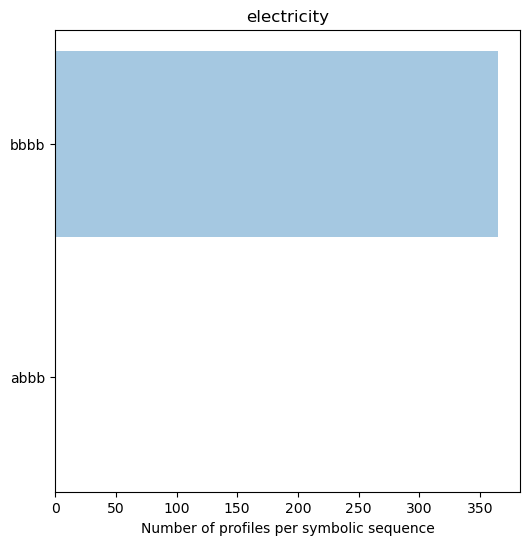

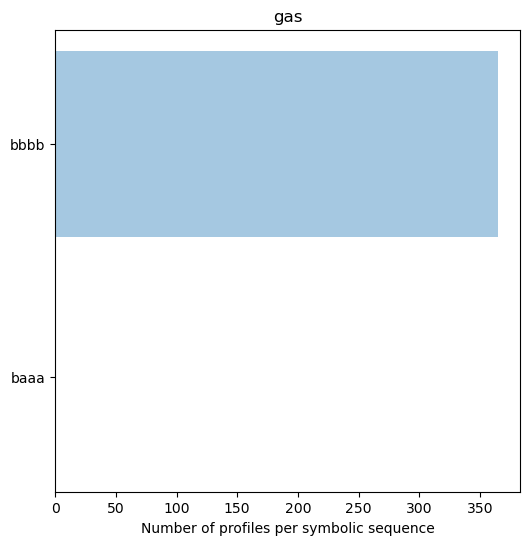

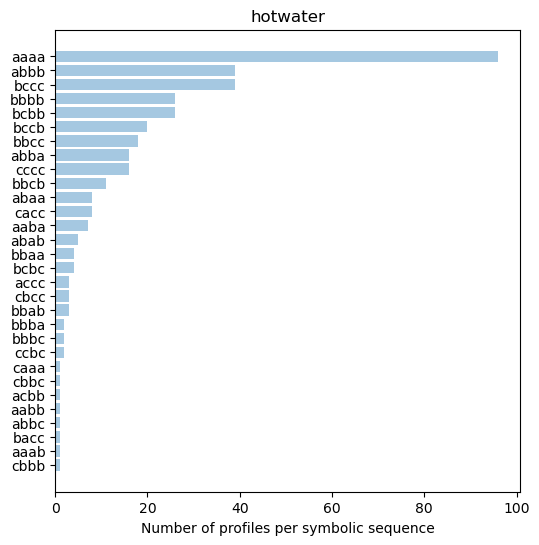

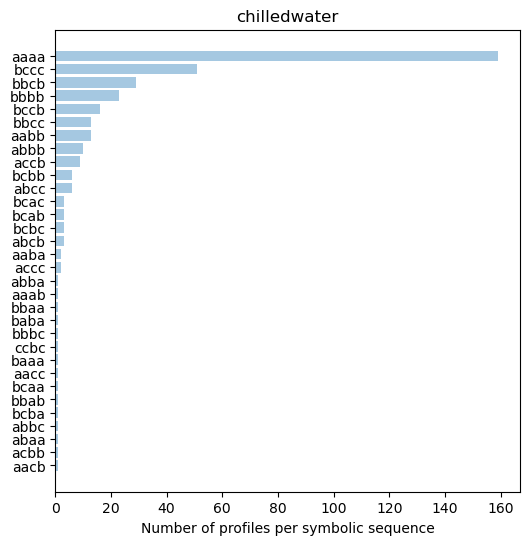

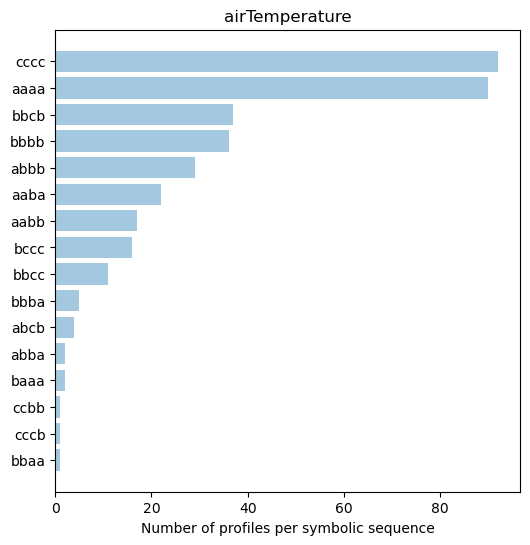

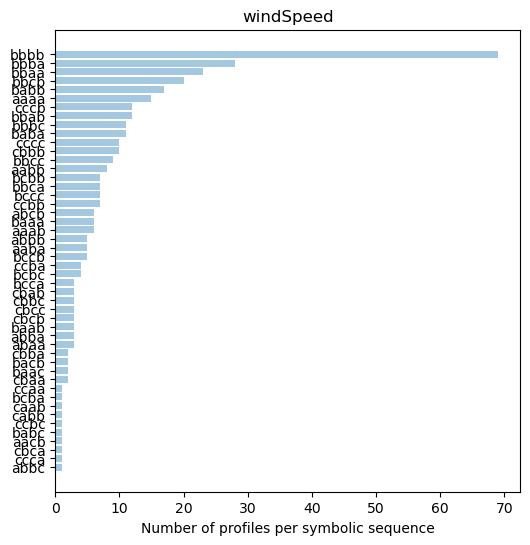

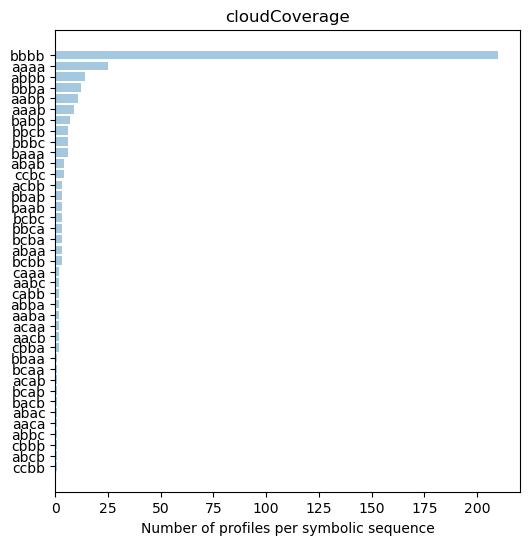

In [40]:
# Perform SAX transformation
sax_dict, counts, sax_data = SAX_mining(df_sax_normalized, W=day_number_of_pieces, A=alphabet_size)

import matplotlib.pyplot as plt
plt.rcdefaults()
def counter_plot(counter, title=None):
    """Simple demo of a horizontal bar chart.
    Source: https://stackoverflow.com/questions/22222573/how-to-plot-counter-object-in-horizontal-bar-chart"""
    # Sort the counter dictionnary per value
    # source: https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
    counter = {k: v for k, v in sorted(counter.items(), key=lambda item: item[1])}
    # Counter data, counter is your counter object
    keys = counter.keys()
    y_pos = np.arange(len(keys))
    # get the counts for each key, assuming the values are numerical
    performance = [counter[k] for k in keys]
    # Now plotting
    fig = plt.figure(figsize=(6, 6))
    plt.barh(y_pos, performance, align='center', alpha=0.4)
    plt.yticks(y_pos, keys)
    plt.xlabel('Number of profiles per symbolic sequence')
    plt.title(title)
    plt.show()
    return fig

# Plot the counts per sequence
for meter in df_cub1.columns.values:
    fig = counter_plot(counts[meter], title=meter)
    fig.savefig(path_out+"SAXCounts_AttribNorm_StandardScaler_blg_"+blg_id+"_meter_"+meter+"_vtest.jpg", dpi=300, bbox_inches='tight')

In [44]:
def sax_df_reformat(sax_data, sax_dict, meter_data, space_btw_saxseq=3):
    """"Function to format a SAX timeseries original data for SAX heatmap plotting."""

    counts[meter_data] = Counter(sax_dict[meter_data])
    # Sort the counter dictionnary per value
    # source: https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
    counter = {k: v for k, v in sorted(counts[meter_data].items(), key=lambda item: item[1])}
    keys = counter.keys()

    empty_sax_df = pd.DataFrame(columns=sax_data[meter_data].columns, index=[' ']*space_btw_saxseq)
    new_sax_df = pd.DataFrame(columns=sax_data[meter_data].columns)
    for sax_seq in keys:
        # Obtaining sax indexes of corresponding profiles within dataframe
        indexes = [i for i,x in enumerate(sax_dict[meter_data]) if x == sax_seq]   # returns all indexes
        # Formating a newdataframe from selected sax_seq
        df_block = sax_data[meter_data].iloc[indexes].copy()
        df_block["SAX"] = [sax_seq]*len(indexes)
        new_sax_df = pd.concat([df_block, empty_sax_df, new_sax_df], axis=0) # Reformated dataframe
    # Mapping the sax sequence to the data
    index_map_dictionary = dict()
    index_map_dictionary["SAX_seq"], index_map_dictionary["SAX_idx"] = [], []
    for sax_seq in keys:
        indexes = [i for i, x in enumerate(new_sax_df["SAX"]) if x == sax_seq]  # returns all indexes
        index_map_dictionary["SAX_seq"].append(sax_seq)
        index_map_dictionary["SAX_idx"].append(np.median(indexes))
    # Droping the SAX column of the dataframe now that we have a mapping variable for it
    new_sax_df.drop("SAX", axis=1, inplace=True)
    return new_sax_df, index_map_dictionary

In [48]:
# SAX map plot function
import plotly.graph_objects as go
from plotly.colors import n_colors
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

def SAX_dailyhm_visualization(dict_numeric, sax_dict, index_map_dictionary, title):
    """"Function to visualize SAX sequences from original dataframe with SAX dictionary"""
    keys = list(sax_dict.keys())
    key_int = 0
    # First loop over all keys and data to identify min and max values of the time series
    for key in sax_dict:    # $key$ can be meter_data or bld_id depending on the cuboid selected
        sax_seq_int = 0
        for sax_sequence_toidentify in sax_dict[key]:
            #sax_sequence_toidentify = "acbb"
            indexes = [i for i, x in enumerate(sax_dict[key]) if x == sax_sequence_toidentify]  # returns all indexes

            if key_int < 1:
                pzmax = dict_numeric[key].iloc[indexes].max().max()
                pzmin = dict_numeric[key].iloc[indexes].min().min()
            else:
                pzmax = max(pzmax, dict_numeric[key].iloc[indexes].max().max())
                pzmin = min(pzmax, dict_numeric[key].iloc[indexes].min().min())
            sax_seq_int = sax_seq_int + 1
        key_int = key_int + 1


    # Calling the subplots
    fig = make_subplots(rows=1, cols=len(keys), shared_yaxes=False, horizontal_spacing=0.01+len(sax_dict[key][0])*0.005,           # to comment/uncomment for per attribute (comment) or per building (uncomment) plotting
                        column_titles=keys, x_title="Hour of the day")
    # Then Loop again of the set to plot
    key_int = 0
    # Looping over sax keys (i.e. attributes or blg keys)
    for key in sax_dict:
        # Plot
        fig.add_trace(go.Heatmap(z=dict_numeric[key],
                                 x=dict_numeric[key].columns,
                                 #y=df_numeric[key].index.values,
                                 # ycalendar=True, xcalendar=True,
                                 zmax=pzmax, zmin=pzmin,
                                 colorbar={"title": "Attribute normalized value"},
                                 colorscale='temps'),
                      row=1, col=key_int + 1)
        fig.update_yaxes(tickmode='array',
                         tickvals=index_map_dictionary[key]["SAX_idx"],
                         ticktext=index_map_dictionary[key]["SAX_seq"],
                         row=1, col=key_int+1)
        key_int = key_int + 1
    fig.update_layout(height=800, width=len(keys)*250,
                      xaxis={"tickmode": "array"},
                      title_text=f"Daily SAX profiles of {title}",
                      plot_bgcolor='#fff'
                      )
    fig.show()
    return fig

In [49]:
# Reformating sax results for plotting
sax_dict_data, index_map_dictionary = dict(), dict()
for meter in sax_data:
    sax_dict_data[meter], index_map_dictionary[meter] = sax_df_reformat(sax_data, sax_dict, meter)

# Plotting and saving figure
fig = SAX_dailyhm_visualization(sax_dict_data, sax_dict, index_map_dictionary, lattice_selected)
fig.write_image(path_out+"SAX_blg_"+lattice_selected+"_vtest.png")

### PER ATTRIBUTE - cuboid selection

In [67]:
## Per attribute insight - 1st column selection
attribute = columns_considered[0]
df_cub2 = df1[attribute]
df_cub2 = reduce_mem_usage(df_cub2, verbose=True)
df_cub2.dropna(axis=1, how='all', inplace=True)
lattice_selected = attribute

## Data manipulation to get daily SAX
df_sax = df_cub2.copy()
# Normalize per attribute robust to Nans
df_sax_normalized = scale_df_columns_NanRobust(df_sax, df_sax.columns, scaler=scaler_function)
sax_dict, counts, sax_data = SAX_mining(df_sax_normalized, W=day_number_of_pieces, A=alphabet_size)

uction)
Mem. usage decreased to  0.02 Mb (72.0% reduction)
Mem. usage decreased to  0.02 Mb (72.0% reduction)
Mem. usage decreased to  0.02 Mb (72.0% reduction)
Mem. usage decreased to  0.02 Mb (72.0% reduction)
Mem. usage decreased to  0.02 Mb (72.0% reduction)
Mem. usage decreased to  0.02 Mb (72.0% reduction)
Mem. usage decreased to  0.02 Mb (72.0% reduction)
Mem. usage decreased to  0.02 Mb (72.0% reduction)
Mem. usage decreased to  0.02 Mb (72.0% reduction)
Mem. usage decreased to  0.02 Mb (72.0% reduction)
Mem. usage decreased to  0.02 Mb (72.0% reduction)
Mem. usage decreased to  0.02 Mb (72.0% reduction)
Mem. usage decreased to  0.02 Mb (72.0% reduction)
Mem. usage decreased to  0.02 Mb (72.0% reduction)
Mem. usage decreased to  0.02 Mb (72.0% reduction)
Mem. usage decreased to  0.02 Mb (72.0% reduction)
Mem. usage decreased to  0.02 Mb (72.0% reduction)
Mem. usage decreased to  0.02 Mb (72.0% reduction)
Mem. usage decreased to  0.02 Mb (72.0% reduction)
Mem. usage decreased to

In [71]:
def sax_count_reformat(sax_dict):
    """"Function to format SAX counts to a unified dataframe."""
    df_concat = [] #pd.DataFrame(columns=df_cub2.columns)
    for meter_data in sax_dict:
        counts[meter_data] = Counter(sax_dict[meter_data])
        # Create a dataframe from the counter object
        df_concat.append(pd.DataFrame.from_dict(counts[meter_data], orient='index', columns=[meter_data]))
    # Now concatenate the dictionary to one dataframe
    df_count = pd.concat(df_concat, axis=1)  # Reformated dataframe
    return df_count

import plotly.figure_factory as ff
def SAXcount_hm_wdendro(df_count, title):
    # Create Side Dendrogram
    # source: https://plotly.com/python/dendrogram/
    dendo = ff.create_dendrogram(df_count.values, orientation='left', labels=list(df_count.index.values))
    for i in range(len(dendo['data'])):
        dendo['data'][i]['xaxis'] = 'x2'
    # Create Heatmap
    dendro_leaves_txt = dendo['layout']['yaxis']['ticktext']
    # Convert the txt leaves to integer index values
    dendro_leaves = []
    for txt in df_count.index.values:
        dendro_leaves.append(list(dendro_leaves_txt).index(txt))
    dendro_leaves = list(map(int, dendro_leaves))

    heat_data = df_count.values[dendro_leaves, :]

    # Calling the subplots
    fig = go.Figure(data=go.Heatmap(z=heat_data,
                                    x=df_count.columns,
                                    y=df_count.index[dendro_leaves],
                                    # zmax=pzmax, zmin=pzmin,
                                    colorbar={"title": "Counts"},
                                    colorscale='Blues'))
    fig.update_layout(height=900, width=len(df_count.columns) * 5,
                      xaxis={"tickmode": "array"},
                      title_text=f"SAX counts for attribute: {title}",
                      plot_bgcolor='#fff'
                      )
    fig.show()
    return fig

In [68]:
## Plotting counts as a heatmap w/ dendrogram organization
df_count = sax_count_reformat(sax_dict)
df_count.fillna(0, inplace=True)
# fig = SAX_counthm_visualization(df_count, title)
fig = SAXcount_hm_wdendro(df_count, lattice_selected)
fig.write_image(path_out+"SAXcounts_wdendro_"+lattice_selected+"_vtest.0.png")

In [73]:
# Reformating daily sax results for plotting all daily SAX
sax_dict_data, index_map_dictionary = dict(), dict()
for meter in sax_data:
    sax_dict_data[meter], index_map_dictionary[meter] = sax_df_reformat(sax_data, sax_dict, meter)
# Plotting all daily SAX and saving figure
fig = SAX_dailyhm_visualization(sax_dict_data, sax_dict, index_map_dictionary, lattice_selected)
fig.write_image(path_out+"SAX_attrib_"+lattice_selected+"_vtest.png")

ValueError: 
    Invalid value of type 'builtins.float' received for the 'domain[1]' property of layout.xaxis
        Received value: -0.02934478371501272

    The 'domain[1]' property is a number and may be specified as:
      - An int or float in the interval [0, 1]